### Welcome!

This notebook illustrates some of the basics of how NestedTensor works, using padding and masking to demonstrate the value NestedTensor can provide when dealing with dynamic input shapes. It assumes you're already familiar with torch and related machine learning concepts, but nothing too involved.

We're currently most interested in collecting feedback on the API design and general usability of this project as per the [prototype classification](https://pytorch.org/blog/pytorch-feature-classification-changes/#prototype) of this feature to decide whether we want to move this feature towards a Beta.  We created an [issue template](https://github.com/pytorch/nestedtensor/issues/new?assignees=&labels=&template=prototype-feedback.md&title=) for feedback, but please also feel encouraged to just open a free-form issue if you like.

### What to expect for now

You're not likely to see wall-clock time improvements in this early version of NestedTensor, and may run into bugs or lack of operator coverage. 

But if you're interested in using NestedTensors for your project, get in touch! You can open an issue with your ideas, and ideally a code snippet that we can use to verify coverage and performance of both forward and backward ops.

Thank you for your interest and for contributing to this project!

### Setup
First we download the binaries. Currently the nestedtensor project ships with its own version of torch and torchvision, since it's built on top of a fork of PyTorch. We recommend you install these binaries in a new environment to keep them separate from your usual PyTorch installation.

You can get links to prebuilt pypi binaries [via our installation matrix](https://github.com/pytorch/nestedtensor#binaries) or build the project [from source](https://github.com/pytorch/nestedtensor#build-for-development). Here we'll install the Python 3.6 binaries for Linux, since that is what colab uses.

In [ ]:
%%capture
!pip install https://download.pytorch.org/nestedtensor/whl/nightly/cpu/py3.6/torch-1.8.0_nestedtensor_0.1.1_cpu-cp36-cp36m-linux_x86_64.whl;
!pip install https://download.pytorch.org/nestedtensor/whl/nightly/cpu/py3.6/nestedtensor-0.1.1_cpu-cp36-cp36m-linux_x86_64.whl;
!pip install https://download.pytorch.org/nestedtensor/whl/nightly/cpu/py3.6/torchvision-0.1.1_cpu-cp36-cp36m-linux_x86_64.whl;

Next we import the necessary packages. nestedtensor is a separate package, but upon import registers itself with torch via its [dispatch registration mechanism](https://pytorch.org/tutorials/advanced/dispatcher.html), which ensures seamless compatibility between NestedTensors and torch Tensors. Let's also download some images for our presentation here.

In [ ]:
%%capture
import torch
import nestedtensor
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
!wget "https://raw.githubusercontent.com/pytorch/nestedtensor/master/tutorials/assets/000000006040.jpg"
!wget "https://raw.githubusercontent.com/pytorch/nestedtensor/master/tutorials/assets/000000017714.jpg"
!wget "https://raw.githubusercontent.com/pytorch/nestedtensor/master/tutorials/assets/000000026926.jpg"
!wget "https://raw.githubusercontent.com/pytorch/nestedtensor/master/tutorials/assets/000000028285.jpg"
EXAMPLE_IMAGE_NAMES = ["000000006040.jpg", "000000017714.jpg", "000000026926.jpg", "000000028285.jpg"]
EXAMPLE_IMAGE_TENSORS = [torchvision.transforms.functional.to_tensor(Image.open(img).convert('RGB')) for img in EXAMPLE_IMAGE_NAMES]

For this tutorial we handselected four beautiful images from the 2017 Validation dataset of the [CODO dataset](https://cocodataset.org/#download).

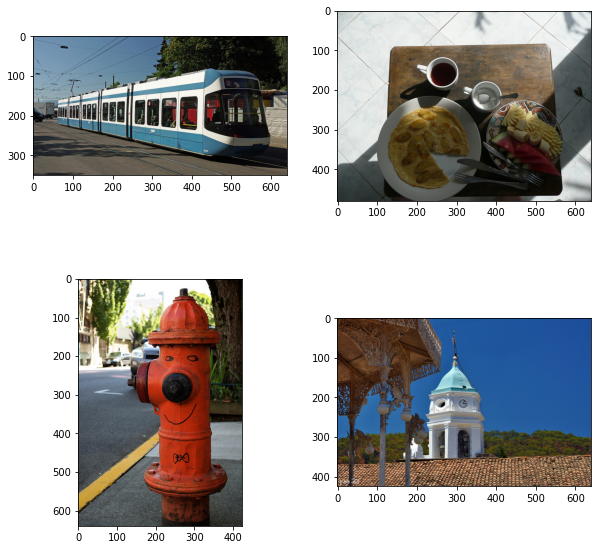

In [ ]:
def display_image_tensors(tensors):
    fig = plt.figure(figsize=(10, 10))
    for i, img in enumerate(tensors):
        fig.add_subplot(2, 2, i + 1)
        plt.imshow(img.permute(1, 2, 0).numpy())
    plt.show()
display_image_tensors(EXAMPLE_IMAGE_TENSORS)

### Concurrently applying conv2d to images of different sizes

Now let's say, for some reason, we want to apply a 2d convolution to each of these images, but they are all of varying sizes. Of course torch's conv2d functional does not accept a list of Tensors, but instead a regular torch tensor of shape N x C x H x W. Let's apply conv2d to the first image to remind ourselves of how this works. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


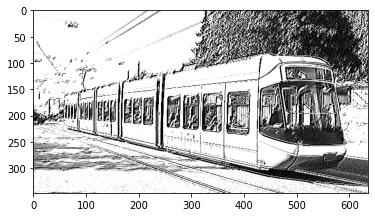

In [ ]:
torch.manual_seed(1010)
weight = torch.randn(5, 5).repeat(3, 3, 1, 1)
result = torch.conv2d(EXAMPLE_IMAGE_TENSORS[0].unsqueeze(0), weight).squeeze(0).permute(1, 2, 0)
plt.imshow(result.numpy())

### Padding by hand

So, we want to apply conv2d to all images at once. This commonly is assumed to happen for performance reasons where most notably GPUs benefit from being allowed to process a lot of data at once. Many PyTorch users know this as "batching" and most do this by hand. Let's step through what this might look like. 

A common approach is to create a single Tensor that contains the data of multiple images by padding the images such that they're all of the same size. These padded images are then merged into a single Tensor and fed into conv2d. 

Since conv2d is applied locally one image patch at a time, the result can then be divided up into the results per image by carefully calculating the region of the output that corresponds to the input.

As you can see in the code that follows, even this relatively simple operation already begins to make the code a bit more obscure and delicate than we'd like.


In [ ]:
max_h = max(t.size(1) for t in EXAMPLE_IMAGE_TENSORS)
max_w = max(t.size(2) for t in EXAMPLE_IMAGE_TENSORS) 
data_tensor = torch.empty(len(EXAMPLE_IMAGE_TENSORS), 3, max_h, max_w)
for i, t in enumerate(EXAMPLE_IMAGE_TENSORS):
    data_tensor[i, :, :t.size(1), :t.size(2)].copy_(t)

Let's look at what these padded images like.

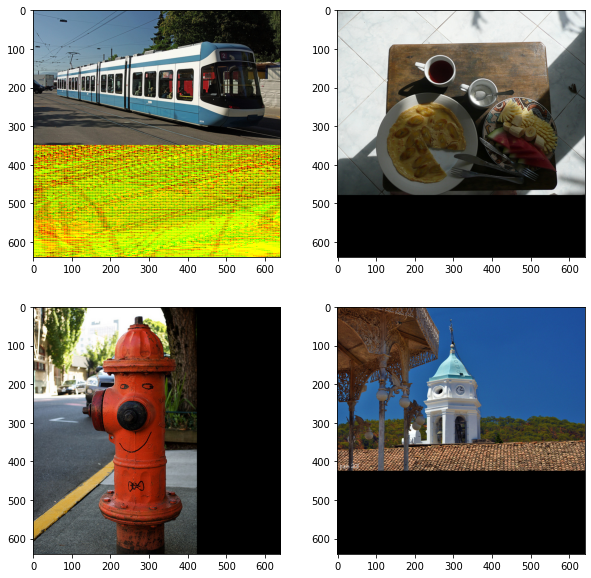

In [ ]:
display_image_tensors(data_tensor.unbind())

It's important to note that we don't actually need to worry what values we are using for padding here. In fact we're using uninitialized memory using [torch.empty](https://pytorch.org/docs/master/generated/torch.empty.html#torch.empty) as given by the operating system, which is why parts of the image can look a bit funny. Convolutions are applied locally, so we just need to calculate the size of the output region and can then crop and retrieve our result.

*This is not the case* for other operations such as max, min, sum, matmul or var, where the operation is applied to the entire Tensor at once. We'll get to that later.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


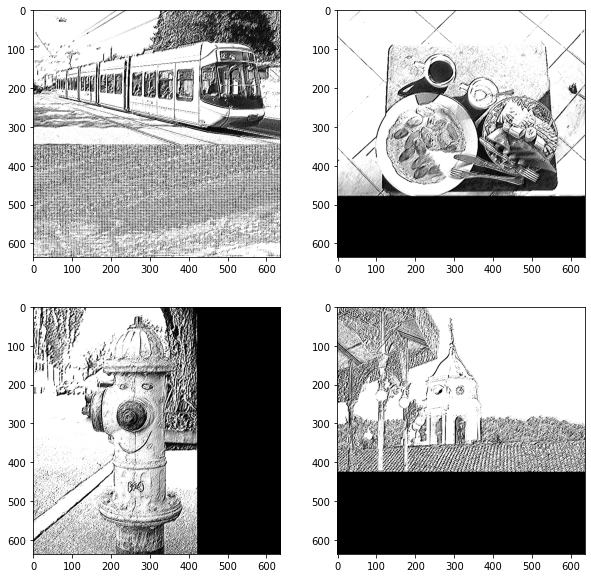

In [ ]:
padded_result = torch.conv2d(data_tensor, weight)
display_image_tensors(padded_result.unbind())

Now let's cut out the output regions and test that they are actually the result we want



In [ ]:
results = []
for orig, result in zip(EXAMPLE_IMAGE_TENSORS, padded_result.unbind()):
  # The output region is 4 pixels smaller than the input because we're applying a 5 by 5 convolution
  results.append(result[:, :orig.size(1) - 4, :orig.size(2) - 4])
  # To test the result we're going to apply conv2d again here but one image at a time
  print(torch.eq(torch.conv2d(orig.unsqueeze(0), weight), results[-1]).all().item())

True
True
True
True


### Using NestedTensor

Here is the *entire operation* using NestedTensor.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


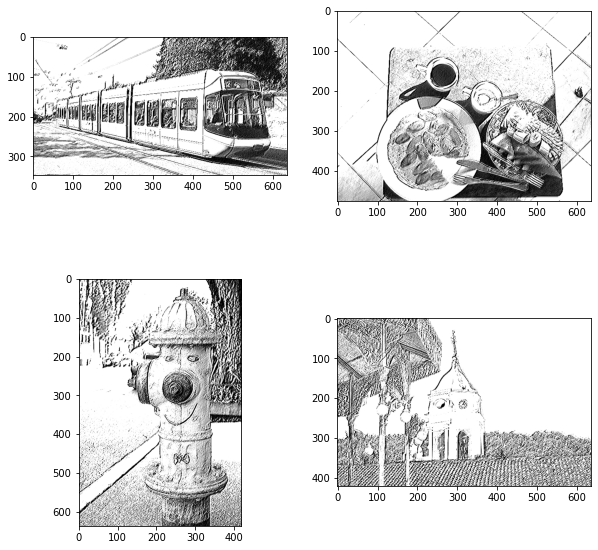

In [ ]:
# 1. Put the images in a NestedTensor
nt = nestedtensor.nested_tensor(EXAMPLE_IMAGE_TENSORS)
# 2. Call conv2d
results_nt = torch.conv2d(nt, weight)

display_image_tensors(results_nt)

### NestedTensor and masking
As we've seen in an earlier section you can use padding to merge images of different sizes and apply an operation (conv2d) concurrently. But there are cases where padding is not enough, in particular when an operation is applied globally to the entire datapoint and the padding values are incorporated into the result. One example here is ```sum``` and ```max```. Let's construct some small Tensors to showcase how padding and masking allows us to apply these reductions concurrently to a list of variably sized data.


In [ ]:
t0 = torch.arange(6).reshape(2, 3).float()
t1 = torch.arange(9).reshape(3, 3).float()
t2 = torch.arange(8).reshape(2, 4).float()
t3 = torch.arange(4).reshape(2, 2).float()
tensors = [t0, t1, t2, t3]
for t in tensors:
    print(t, "\n")

tensor([[0., 1., 2.],
        [3., 4., 5.]]) 

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]]) 

tensor([[0., 1., 2., 3.],
        [4., 5., 6., 7.]]) 

tensor([[0., 1.],
        [2., 3.]]) 



In [ ]:
max_size_0 = max(t.size(0) for t in tensors)
max_size_1 = max(t.size(1) for t in tensors) 
data_tensor = torch.zeros(len(tensors), max_size_0, max_size_1)
for i, t in enumerate(tensors):
    data_tensor[i, :t.size(0), :t.size(1)].copy_(t)
print(data_tensor)

tensor([[[0., 1., 2., 0.],
         [3., 4., 5., 0.],
         [0., 0., 0., 0.]],

        [[0., 1., 2., 0.],
         [3., 4., 5., 0.],
         [6., 7., 8., 0.]],

        [[0., 1., 2., 3.],
         [4., 5., 6., 7.],
         [0., 0., 0., 0.]],

        [[0., 1., 0., 0.],
         [2., 3., 0., 0.],
         [0., 0., 0., 0.]]])


In [ ]:
results = []
for result_t, t in zip(torch.sum(data_tensor, dim=1), tensors):
    results.append(result_t[:t.size(1)])
    print(torch.equal(result_t[:t.size(1)], torch.sum(t, dim=0)))
print(results)

True
True
True
True
[tensor([3., 5., 7.]), tensor([ 9., 12., 15.]), tensor([ 4.,  6.,  8., 10.]), tensor([2., 4.])]


This works because the Tensor is padded with 0s. Since it's up to the user to choose what values are meant to be used for padding that's fine.

Or equivalently using NestedTensor via the same operator

In [ ]:
print(nestedtensor.nested_tensor(tensors).sum(1))

nested_tensor([
  tensor([3., 5., 7.]),
  tensor([ 9., 12., 15.]),
  tensor([ 4.,  6.,  8., 10.]),
  tensor([2., 4.])
])


When using padding and masking we always need some kind of information to recover the portion of data from the result that is relevant. We can store the shape of the individual Tensors and manually update them to do the retrieval, or alternatively we could use a mask to signify which elements are valid. This also provides us with an alternative way of calculating the sum that doesn't depend on the values that were used for padding.

In [ ]:
max_size_0 = max(t.size(0) for t in tensors)
max_size_1 = max(t.size(1) for t in tensors) 
data_tensor = torch.zeros(len(tensors), max_size_0, max_size_1)
mask_tensor = torch.zeros_like(data_tensor)
for i, t in enumerate(tensors):
    data_tensor[i, :t.size(0), :t.size(1)].copy_(t)
    mask_tensor[i, :t.size(0), :t.size(1)].fill_(1)
print(data_tensor)
print(mask_tensor)

tensor([[[0., 1., 2., 0.],
         [3., 4., 5., 0.],
         [0., 0., 0., 0.]],

        [[0., 1., 2., 0.],
         [3., 4., 5., 0.],
         [6., 7., 8., 0.]],

        [[0., 1., 2., 3.],
         [4., 5., 6., 7.],
         [0., 0., 0., 0.]],

        [[0., 1., 0., 0.],
         [2., 3., 0., 0.],
         [0., 0., 0., 0.]]])
tensor([[[1., 1., 1., 0.],
         [1., 1., 1., 0.],
         [0., 0., 0., 0.]],

        [[1., 1., 1., 0.],
         [1., 1., 1., 0.],
         [1., 1., 1., 0.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [0., 0., 0., 0.]],

        [[1., 1., 0., 0.],
         [1., 1., 0., 0.],
         [0., 0., 0., 0.]]])


In [ ]:
result = torch.bmm(mask_tensor.transpose(1, 2)[:, :1, :], data_tensor).squeeze(1)
result_mask = mask_tensor.max(1)[0]
for result_t, mask_t, t in zip(result.unbind(), result_mask.unbind(), tensors):
    print(torch.equal(torch.sum(t, dim=0), result_t[:int(mask_t.sum().item())]))


True
True
True
True


As a bonus [bmm (batch matrix multiply)](https://pytorch.org/docs/master/generated/torch.bmm.html#torch.bmm) will use efficient matrix multiplication kernels, but it does require the mask to be of type float (there is no explicit support for boolean values yet).

Both of these approaches work for summation, but what if we wanted to calculate the maximum instead of doing a summation now?

One approach here is to change the value we use for padding. In particular we need to fill the data Tensor with the smallest possible value a particular dtype can represent. It's important to pick the right value for that, but luckily we have [torch.finfo](https://pytorch.org/docs/master/type_info.html#torch-finfo).

In [ ]:
max_size_0 = max(t.size(0) for t in tensors)
max_size_1 = max(t.size(1) for t in tensors) 
min_value = torch.finfo(torch.float32).min
data_tensor = torch.zeros(len(tensors), max_size_0, max_size_1).fill_(min_value)
for i, t in enumerate(tensors):
    data_tensor[i, :t.size(0), :t.size(1)].copy_(t)
print(data_tensor.max(1)[0])

tensor([[ 3.0000e+00,  4.0000e+00,  5.0000e+00, -3.4028e+38],
        [ 6.0000e+00,  7.0000e+00,  8.0000e+00, -3.4028e+38],
        [ 4.0000e+00,  5.0000e+00,  6.0000e+00,  7.0000e+00],
        [ 2.0000e+00,  3.0000e+00, -3.4028e+38, -3.4028e+38]])


If we're doing this reduction as a follow-up to the previous summation we might utilize the mask to fill the padding values. It just needs to be of boolean dtype and inverted, but might be faster than reallocating memory and then copying into the subtensors.

In [ ]:
max_size_0 = max(t.size(0) for t in tensors)
max_size_1 = max(t.size(1) for t in tensors) 
data_tensor = torch.zeros(len(tensors), max_size_0, max_size_1)
mask_tensor = torch.zeros_like(data_tensor, dtype=torch.bool)
for i, t in enumerate(tensors):
    data_tensor[i, :t.size(0), :t.size(1)].copy_(t)
    mask_tensor[i, :t.size(0), :t.size(1)].fill_(1)
data_tensor.masked_fill_(~mask_tensor, torch.finfo(torch.float32).min)
print(data_tensor.max(1)[0])

tensor([[ 3.0000e+00,  4.0000e+00,  5.0000e+00, -3.4028e+38],
        [ 6.0000e+00,  7.0000e+00,  8.0000e+00, -3.4028e+38],
        [ 4.0000e+00,  5.0000e+00,  6.0000e+00,  7.0000e+00],
        [ 2.0000e+00,  3.0000e+00, -3.4028e+38, -3.4028e+38]])


Of course with NestedTensor you just use max instead of sum to do this.

In [ ]:
print(nestedtensor.nested_tensor(tensors).max(1)[0])

nested_tensor([
  tensor([3., 4., 5.]),
  tensor([6., 7., 8.]),
  tensor([4., 5., 6., 7.]),
  tensor([2., 3.])
])


As a convenience function you can also construct nestedtensors from a padded and masked version of your data, as long as the mask is boolean and matches the shape of the data Tensor. This is useful when you want to gradually apply NestedTensor in the context of a pipeline where you already are using padding and masking.

In [ ]:
tensor = torch.tensor(
        [[[0.8413, 0.7325, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.6334, 0.5473, 0.3273, 0.0564],
         [0.3023, 0.6826, 0.3519, 0.1804],
         [0.8431, 0.1645, 0.1821, 0.9185]]])
mask = torch.tensor(
        [[[ True,  True, False, False],
         [False, False, False, False],
         [False, False, False, False]],

        [[ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True]]])
nt2 = nestedtensor.nested_tensor_from_tensor_mask(tensor, mask)
print(nestedtensor.nested_tensor_from_tensor_mask(tensor, mask))
print(nestedtensor.nested_tensor_from_padded_tensor(tensor, padding=0))

nested_tensor([
  tensor([[0.8413, 0.7325]]),
  tensor([[0.6334, 0.5473, 0.3273, 0.0564],
          [0.3023, 0.6826, 0.3519, 0.1804],
          [0.8431, 0.1645, 0.1821, 0.9185]])
])
nested_tensor([
  tensor([[0.8413, 0.7325]]),
  tensor([[0.6334, 0.5473, 0.3273, 0.0564],
          [0.3023, 0.6826, 0.3519, 0.1804],
          [0.8431, 0.1645, 0.1821, 0.9185]])
])


Likewise you can also convert from a NestedTensor into a pair of data and a corresponding mask.

In [ ]:
data, mask = nt2.to_tensor_mask()
print(data)
print(mask)

tensor([[[0.8413, 0.7325, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.6334, 0.5473, 0.3273, 0.0564],
         [0.3023, 0.6826, 0.3519, 0.1804],
         [0.8431, 0.1645, 0.1821, 0.9185]]])
tensor([[[ True,  True, False, False],
         [False, False, False, False],
         [False, False, False, False]],

        [[ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True]]])


In [ ]:
print(nt2.to_padded_tensor(padding=-10))

tensor([[[  0.8413,   0.7325, -10.0000, -10.0000],
         [-10.0000, -10.0000, -10.0000, -10.0000],
         [-10.0000, -10.0000, -10.0000, -10.0000]],

        [[  0.6334,   0.5473,   0.3273,   0.0564],
         [  0.3023,   0.6826,   0.3519,   0.1804],
         [  0.8431,   0.1645,   0.1821,   0.9185]]])


### Under the hood

Let's take a second and look at what a NestedTensor looks like.

For now it simply prints as a nested list of Tensors.

In [ ]:
print(nt)

nested_tensor([
  tensor([[[0.4431, 0.4431, 0.4353,  ..., 0.1451, 0.0784, 0.0627],
           [0.4471, 0.4431, 0.4392,  ..., 0.1137, 0.0784, 0.0627],
           [0.4510, 0.4471, 0.4392,  ..., 0.1137, 0.0118, 0.1255],
           ...,
           [0.1765, 0.1608, 0.1765,  ..., 0.3294, 0.3725, 0.3686],
           [0.2078, 0.2039, 0.2314,  ..., 0.4275, 0.3333, 0.3412],
           [0.2118, 0.2235, 0.2471,  ..., 0.4000, 0.4392, 0.4353]],
  
          [[0.5647, 0.5647, 0.5647,  ..., 0.1490, 0.0824, 0.0667],
           [0.5686, 0.5647, 0.5686,  ..., 0.1176, 0.0824, 0.0745],
           [0.5725, 0.5686, 0.5686,  ..., 0.1216, 0.0196, 0.1451],
           ...,
           [0.1843, 0.1647, 0.1765,  ..., 0.2745, 0.3176, 0.3059],
           [0.2118, 0.2078, 0.2353,  ..., 0.3882, 0.2941, 0.3098],
           [0.2196, 0.2314, 0.2549,  ..., 0.3451, 0.3882, 0.3961]],
  
          [[0.6863, 0.6863, 0.6863,  ..., 0.1294, 0.0510, 0.0353],
           [0.6902, 0.6863, 0.6902,  ..., 0.0863, 0.0588, 0.0471],
      

We can unbind a NestedTensor (which is already a regular, but lesser known torch Tensor operation with the same behavior) to get an actual Python list and take a closer look at some of the constituents.

In [ ]:
print(nt.unbind()[0])

tensor([[[0.4431, 0.4431, 0.4353,  ..., 0.1451, 0.0784, 0.0627],
         [0.4471, 0.4431, 0.4392,  ..., 0.1137, 0.0784, 0.0627],
         [0.4510, 0.4471, 0.4392,  ..., 0.1137, 0.0118, 0.1255],
         ...,
         [0.1765, 0.1608, 0.1765,  ..., 0.3294, 0.3725, 0.3686],
         [0.2078, 0.2039, 0.2314,  ..., 0.4275, 0.3333, 0.3412],
         [0.2118, 0.2235, 0.2471,  ..., 0.4000, 0.4392, 0.4353]],

        [[0.5647, 0.5647, 0.5647,  ..., 0.1490, 0.0824, 0.0667],
         [0.5686, 0.5647, 0.5686,  ..., 0.1176, 0.0824, 0.0745],
         [0.5725, 0.5686, 0.5686,  ..., 0.1216, 0.0196, 0.1451],
         ...,
         [0.1843, 0.1647, 0.1765,  ..., 0.2745, 0.3176, 0.3059],
         [0.2118, 0.2078, 0.2353,  ..., 0.3882, 0.2941, 0.3098],
         [0.2196, 0.2314, 0.2549,  ..., 0.3451, 0.3882, 0.3961]],

        [[0.6863, 0.6863, 0.6863,  ..., 0.1294, 0.0510, 0.0353],
         [0.6902, 0.6863, 0.6902,  ..., 0.0863, 0.0588, 0.0471],
         [0.6941, 0.6902, 0.6902,  ..., 0.0706, 0.0000, 0.

or simply use indexing

In [ ]:
print(nt[0])

tensor([[[0.4431, 0.4431, 0.4353,  ..., 0.1451, 0.0784, 0.0627],
         [0.4471, 0.4431, 0.4392,  ..., 0.1137, 0.0784, 0.0627],
         [0.4510, 0.4471, 0.4392,  ..., 0.1137, 0.0118, 0.1255],
         ...,
         [0.1765, 0.1608, 0.1765,  ..., 0.3294, 0.3725, 0.3686],
         [0.2078, 0.2039, 0.2314,  ..., 0.4275, 0.3333, 0.3412],
         [0.2118, 0.2235, 0.2471,  ..., 0.4000, 0.4392, 0.4353]],

        [[0.5647, 0.5647, 0.5647,  ..., 0.1490, 0.0824, 0.0667],
         [0.5686, 0.5647, 0.5686,  ..., 0.1176, 0.0824, 0.0745],
         [0.5725, 0.5686, 0.5686,  ..., 0.1216, 0.0196, 0.1451],
         ...,
         [0.1843, 0.1647, 0.1765,  ..., 0.2745, 0.3176, 0.3059],
         [0.2118, 0.2078, 0.2353,  ..., 0.3882, 0.2941, 0.3098],
         [0.2196, 0.2314, 0.2549,  ..., 0.3451, 0.3882, 0.3961]],

        [[0.6863, 0.6863, 0.6863,  ..., 0.1294, 0.0510, 0.0353],
         [0.6902, 0.6863, 0.6902,  ..., 0.0863, 0.0588, 0.0471],
         [0.6941, 0.6902, 0.6902,  ..., 0.0706, 0.0000, 0.

### nested_size

Since NestedTensors are strictly more general in their shape than torch Tensors we introduce new methods called nested_size (and nested stride) to get a representation for their shape. 

NestedTensors still carry sizes, but they may be undefined (None) along some of the dimensions. See the next section on more details for a stricter definition, but roughly speaking, size is None when *constiuent sizes are non-uniform along that dimension*. 

In the example below the constituents of NestedTensor `nt` have sizes of 351, 480, 640 and 425 along their second dimensions, which means the size along the third dimension of `nt` is None. 

Similarly, constituents are non-uniform along their third dimensions, making `nt`'s fourth dimension None as well.


In [ ]:
print(nt.nested_size())
print(nt.size())

NestedSize([
	torch.Size([3, 351, 640]),
	torch.Size([3, 480, 640]),
	torch.Size([3, 640, 423]),
	torch.Size([3, 425, 640])
])
(4, 3, None, None)


### Other Tensor properties are unchanged

A NestedTensor is very similar to a regular torch Tensor, with the only key difference that its shape can be more complex. That means most importantly that a NestedTensor size (and stride) can be irregular and for some dimensions may not be defined (hence None). Instead NestedTensors come with a nested_size and a nested_stride.

Everything else still applies. It still only has a single dimension, single dtype, single layout, single device. And it is backed by a single, contiguous region of memory.


In [ ]:
print(nt.dim())
print(nt.layout)
print(nt.device)
print(nt.dtype)
print(nt.numel())

4
torch.strided
cpu
torch.float32
3223680


A NestedTensor is semantically interchangeable with a regular Tensor if its nested_size is regular and regular torch operators will behave just as expected. It is only when a NestedTensor's shape becomes irregular, that an operator might behave differently.

In [ ]:
nt_tensor = nestedtensor.nested_tensor(8 * [torch.randn(3, 100, 100)])
print(nt_tensor.nested_size())
print(nt_tensor.size())

NestedSize([
	torch.Size([3, 100, 100]),
	torch.Size([3, 100, 100]),
	torch.Size([3, 100, 100]),
	torch.Size([3, 100, 100]),
	torch.Size([3, 100, 100]),
	torch.Size([3, 100, 100]),
	torch.Size([3, 100, 100]),
	torch.Size([3, 100, 100])
])
(8, 3, 100, 100)


*Design note: We could have alternatively attempted to generalize torch.Tensor by introducing a nested_size method and nested_tensor constructor to produce irregular torch.Tensors, but introducing a separate construct (namely NestedTensor) is presumably easier at first.*


### Interop example: resnet18

To showcase just how similar NestedTensors are to regular Tensors let us feed one into a torchvision resnet18.

In [ ]:
model = torchvision.models.resnet.resnet18(pretrained=True).eval()
result_model_nt = model(nestedtensor.nested_tensor(EXAMPLE_IMAGE_TENSORS)).unbind()
# The outputs won't match bit-perfect, but they are allclose
for i, img in enumerate(EXAMPLE_IMAGE_TENSORS):
   a = result_model_nt[i]
   b = model(img.unsqueeze(0)).squeeze(0)
   # atol and rtol from PyTorch test settings found here https://github.com/pytorch/pytorch/blob/2fe382e931ec5a31715c247fea2b292f7d72cb66/torch/testing/_internal/common_utils.py#L921
   print(torch.allclose(a, b, atol=1e-5, rtol=1.3e-6))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



True
True
True
True


### Shape properties of NestedTensors
Let's spend a bit more time going into the details of NestedTensor properties. Let's use our example tensors as an input to construct a NestedTensor.

In [ ]:
nt = nestedtensor.nested_tensor(EXAMPLE_IMAGE_TENSORS)
print(nt.nested_dim())
print(nt.tensor_dim())
print(nt.dim())

1
3
4


Every non-empty NestedTensor is of at least dimension one, because it must represent at least a list. For each level of lists with list entries added we increase the nested dimension by one. That means this NestedTensor is of nested dimension 1.

The tensor dimension is three, because the Tensor constituents are of dimension three.

The overall dimension is four because it is the sum of the nested and tensor dimension.


Here is another quick example, but this time with nested dimension two.

In [ ]:
a = torch.tensor([[1]])
b = torch.tensor([[2, 2],
                  [3, 3],
                  [4, 4],
                  [5, 5]])
nt2 = nestedtensor.nested_tensor([[a], [b]])
print(nt2)
print(nt2.nested_dim())
print(nt2.tensor_dim())
print(nt2.dim())

nested_tensor([
  [
    tensor([[1.]])
  ],
  [
    tensor([[2., 2.],
            [3., 3.],
            [4., 4.],
            [5., 5.]])
  ]
])
2
2
4


NestedTensor.nested_size can be thought of as the result of replacing the regular Tensor constituents by their size.

NestedTensor.nested_size optionally also accepts a dim argument. This will return a slice across the given dimension. This might be easier to explain via an example below.

nt2.nested_size(0) returns the length of nt or the number of entries in the list it represents. This is very similar to ```list.__len__```.

nt2.nested_size(1) returns the length of the entries of the outer list.

nt2.nested_size(2) returns the first entry of each Tensor constiuent's size. 

nt2.nested_size(3) returns the second entry of each Tensor constiuent's size.


In [ ]:
print(nt2)
print(nt2.nested_size())
print(len(nt2))
print(nt2.nested_size(0))
print(nt2.nested_size(1))
print(nt2.nested_size(2))
print(nt2.nested_size(3))

nested_tensor([
  [
    tensor([[1.]])
  ],
  [
    tensor([[2., 2.],
            [3., 3.],
            [4., 4.],
            [5., 5.]])
  ]
])
NestedSize([
	NestedSize([
		torch.Size([1, 1])
	]),
	NestedSize([
		torch.Size([4, 2])
	])
])
2
2
(1, 1)
((1,), (4,))
((1,), (2,))


This property might appear a bit cumbersome, but can actually be very useful when you're trying to use the per-element length information in an operation. An example here is summing all word embeddings in a list of sentences and dividing them by their length.

In [ ]:
sentences = [
    # We're using arange to make the result easier to reason about
    torch.arange(50).reshape(10, 5),
    torch.arange(25).reshape(5, 5),
    torch.arange(45).reshape(9, 5)]
nt = nestedtensor.nested_tensor(sentences)
print(nt)
lengths = torch.tensor(nt.nested_size(1)).reshape(-1, 1)
print(lengths)
print(nt.sum(1).size())
print(lengths.size())

nested_tensor([
  tensor([[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.],
          [25., 26., 27., 28., 29.],
          [30., 31., 32., 33., 34.],
          [35., 36., 37., 38., 39.],
          [40., 41., 42., 43., 44.],
          [45., 46., 47., 48., 49.]]),
  tensor([[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]),
  tensor([[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.],
          [25., 26., 27., 28., 29.],
          [30., 31., 32., 33., 34.],
          [35., 36., 37., 38., 39.],
          [40., 41., 42., 43., 44.]])
])
tensor([[10],
        [ 5],
        [ 9]])
(3, 5)
torch.Size([3, 1])


In [ ]:
normalized = nt.sum(1) / lengths
print(normalized.nested_size())
print(normalized)

NestedSize([
	torch.Size([5]),
	torch.Size([5]),
	torch.Size([5])
])
nested_tensor([
  tensor([22.5000, 23.5000, 24.5000, 25.5000, 26.5000]),
  tensor([10., 11., 12., 13., 14.]),
  tensor([20., 21., 22., 23., 24.])
])


NestedTensor.size is a function that returns a tuple of the format
(n_1, n_2, ..., n_nested_dim, t_1, t_2, ..., t_tensor_dim). The sizes lead by n_ are defined 
to be the nested sizes each at a nested dimension, the sizes lead by t_ are defined to be the 
tensor sizes each at a tensor dimension. They are a reduced version of nested_size and 
aim to represent the size across a slice of nested_size.

size(i) is of value k if all numerical entries of nested_size(dim) are of value k. size(i) is None if there does not exist such value k. size() is a tuple consisting of size(i).

In [ ]:
print(nt2.nested_size())
print(nt2.nested_size(0))
print(nt2.nested_size(1))
print(nt2.nested_size(2))
print(nt2.nested_size(3))
print(nt2.size())

NestedSize([
	NestedSize([
		torch.Size([1, 1])
	]),
	NestedSize([
		torch.Size([4, 2])
	])
])
2
(1, 1)
((1,), (4,))
((1,), (2,))
(2, 1, None, None)


### NestedTensor and text classification

Let's first look how we can feed NestedTensors into nn.Transformer and afterwards let's step through a small end-to-end example with a regular nn.EmbeddingBag.



In [ ]:
EMBED_DIM = 32
NHEAD = 8
t = torch.nn.Transformer(EMBED_DIM, NHEAD, dropout=0.0)

src0 = torch.randn(2, EMBED_DIM)
src1 = torch.randn(4, EMBED_DIM)
nt_src = nestedtensor.nested_tensor([src0, src1])

tgt0 = torch.randn(3, EMBED_DIM)
tgt1 = torch.randn(5, EMBED_DIM)
nt_tgt = nestedtensor.nested_tensor([tgt0, tgt1])

res_0 = t(src0.unsqueeze(1), tgt0.unsqueeze(1)).squeeze(1)
res_1 = t(src1.unsqueeze(1), tgt1.unsqueeze(1)).squeeze(1)
res_nt = t(nt_src, nt_tgt)

for t0, t1 in zip(res_nt.unbind(), [res_0, res_1]):
    print(torch.equal(t0, t1))

True
True


Let's fetch some data (DBPedia in this case) and print a line of example text and associated class.

In [ ]:
import requests
import io
import tarfile
URL = "https://github.com/le-scientifique/torchDatasets/raw/master/dbpedia_csv.tar.gz"
def get_data(URL):
    tar = tarfile.open(fileobj=io.BytesIO(requests.get(URL).content))
    d = {}
    for member in tar.getmembers():
        if member.isfile() and member.name.endswith('csv'):
            k = 'train' if 'train' in member.name else 'test'
            d[k] = tar.extractfile(member)
    return d
data = get_data(URL)
print(next(data['train']))


b'1,"E. D. Abbott Ltd"," Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929. A major part of their output was under sub-contract to motor vehicle manufacturers. Their business closed in 1972."\n'


Next we do some basic preprocessing: lower-casing, removing non-alphanumeric characters, skipping empty lines and splitting out the class index associated to the text. 

In [ ]:
import re
prog = re.compile(r'[^0-9a-zA-Z,\s]')
def preprocess(iterator):
    def _preprocess(line):
        line = line.decode('UTF-8').lower()
        line = prog.sub("", line)
        line = line.split(',')
        label = line[0]
        text = (" ".join(line[1:])).split()
        if len(line) > 2:
            return text, label
    for line in iterator:
        yield _preprocess(line)

data = get_data(URL)
data = {k: list(preprocess(v)) for (k, v) in data.items()}

Now to numericalize the text we associate a unique number to each token via a vocabulary.

In [ ]:
from collections import Counter
def build_vocab(iterator):
    counter = Counter()
    for line in iterator:
      counter.update(line)
    vocab = {}
    for i, (entry, freq) in enumerate(counter.most_common()):
        vocab[entry] = i
    return vocab

vocab = build_vocab(iter(text for text, label in data['train']))
labels = build_vocab(iter([label] for text, label in data['train']))
print(labels)
print(list(vocab.keys())[:10])

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, '10': 9, '11': 10, '12': 11, '13': 12, '14': 13}
['the', 'in', 'of', 'a', 'is', 'and', 'was', 'by', 'to', 'it']


Now that we have our preprocessing setup we can turn a line of text into an input tensor of integers and a class label. Next we can get started on setting up our model. If we can't find a word within the text vocabulary we'll associate it to ```len(vocab)``` as a catch-all index.

In [ ]:
def to_tensor(datapoint):
    line, label = datapoint
    input = torch.tensor(list(vocab.get(word, len(vocab)) for word in line))
    target = torch.tensor(labels[label])
    return input, target

input, target = to_tensor(data['train'][0])
print(input)
print(target)

tensor([  545,   457,  7547,   727,  7547,     2, 15414,   545,   457,  7547,
          526,     6,     3,    99, 72076,   317,    73,     1, 15414,  3769,
         2477,   126,    34,    64,    14,  1248,     3,   300,    75,     2,
          111,  7420,     6,   126, 37577,     8,  1198,  1646,  3889,   111,
          317,  1669,     1,   600])
tensor(0)


Let's setup a very basic text classification model for this.

In [ ]:
class TextSentiment(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = torch.nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = torch.nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        return self.fc(self.embedding(text))

model = TextSentiment(len(vocab) + 1, 10, len(labels))

If you're familiar with [nn.EmbeddingBag](https://pytorch.org/docs/master/generated/torch.nn.EmbeddingBag.html#torch.nn.EmbeddingBag) you know that it currently supports variable shape input via flat data + offset data representation. Let's feed in the first 10 lines of text to demonstrate this.

In particular, offsets need to represent the starting points of each line of indices

In [ ]:
first_ten = data['train'][:10]
first_ten_tensors = tuple(to_tensor(line)[0] for line in first_ten)

input_batch_data = torch.cat(first_ten_tensors)
input_batch_offset = torch.cat((torch.tensor([0]), torch.tensor(tuple(len(line[0]) for line in first_ten))))
input_batch_offset = input_batch_offset.cumsum(0)[:-1]
embedding = torch.nn.EmbeddingBag(len(vocab) + 1, 10, sparse=True)
print(input_batch_offset)
result_tensor = embedding(input_batch_data, input_batch_offset)
print(result_tensor.size())

tensor([  0,  44,  77, 149, 182, 205, 245, 300, 363, 408])
torch.Size([10, 10])


Due to cumsum this isn't all that painful, but NestedTensor does clean it up a little bit

In [ ]:
nt = nestedtensor.nested_tensor(first_ten_tensors, dtype=torch.int64)
print(nt.nested_size())
result_nt = embedding(nestedtensor.nested_tensor(first_ten_tensors, dtype=torch.int64))
print(result_nt.nested_size())

NestedSize([
	torch.Size([44]),
	torch.Size([33]),
	torch.Size([72]),
	torch.Size([33]),
	torch.Size([23]),
	torch.Size([40]),
	torch.Size([55]),
	torch.Size([63]),
	torch.Size([45]),
	torch.Size([57])
])
NestedSize([
	torch.Size([10]),
	torch.Size([10]),
	torch.Size([10]),
	torch.Size([10]),
	torch.Size([10]),
	torch.Size([10]),
	torch.Size([10]),
	torch.Size([10]),
	torch.Size([10]),
	torch.Size([10])
])


Underneath the hood NestedTensor simply translates into the format required by EmbeddingBag, but doesn't bother the user with converting into this format manually. This is why we get equality in the output.

In [ ]:
for t0, t1 in zip(result_tensor.unbind(), result_nt.unbind()):
  print(torch.equal(t0, t1))

True
True
True
True
True
True
True
True
True
True


Now that we know what this looks like let's train the model.

In [ ]:
import random
import sys
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

batch_size = 32
random.shuffle(data['train'])
for i in range(0, len(data['train']), batch_size):
    inputs, targets = zip(*map(to_tensor, data['train'][i:i+batch_size]))
    optimizer.zero_grad()
    output = model(nestedtensor.nested_tensor(inputs, dtype=torch.int64))
    loss = criterion(output.to_tensor(), torch.tensor(targets))
    loss.backward()
    optimizer.step()
    sys.stderr.write("\rloss: {:3.6f} progress: {:3.6f}".format(loss.item(), 100 * float(i) / len(data['train'])))

loss: 0.262292 progress: 99.994286

We're using a new method ```to_tensor``` here that converts a NestedTensor into a torch.Tensor, if the NestedTensor is of **Tensor shape**. With this we mean that its .size() attribute does not have any None entries. It means it is entirely regular. 

This operation has autograd support and can be used to make use of NestedTensor when an operation (in this case CrossEntropyLoss) isn't implemented.

Here is a quick example to show how it works:

In [ ]:
tensors = [torch.randn(5, 2), torch.randn(3, 5)]
nt = nestedtensor.nested_tensor(tensors)
print(nt.nested_size())
print(nt.size())
try:
  nt.to_tensor()
except IndexError as e:
  print(e)

NestedSize([
	torch.Size([5, 2]),
	torch.Size([3, 5])
])
(2, None, None)
to_tensor()/to_tensor(0) only works if there is no None in size().


In [ ]:
tensors = [torch.arange(10).reshape(2, 5), torch.arange(10).reshape(2, 5)]
nt = nestedtensor.nested_tensor(tensors)
print(nt.nested_size())
print(nt.to_tensor())
print(nt.to_tensor().size())

NestedSize([
	torch.Size([2, 5]),
	torch.Size([2, 5])
])
tensor([[[0., 1., 2., 3., 4.],
         [5., 6., 7., 8., 9.]],

        [[0., 1., 2., 3., 4.],
         [5., 6., 7., 8., 9.]]])
torch.Size([2, 2, 5])


Now that we trained this model for one epoch, we can evaluate it on the test set to see if we got a reasonable number.

In [ ]:
accuracy = 0
for i in range(0, len(data['test']), batch_size):
    inputs, targets = zip(*map(to_tensor, data['train'][i:i+batch_size]))
    nt = nestedtensor.nested_tensor(inputs, dtype=torch.int64)
    output = model(nt).to_tensor().argmax(1)
    accuracy += (output == torch.stack(targets)).sum().item()
print(accuracy / len(data['test']))

0.9691285714285715


### Summary
This was a bit of a whirlwind tour to show the basics of the value behind the nestedtensor project and illustrate some of the basic NestedTensor behavior and properties. 

Thank you for your time and thank you for reading this tutorial.

We're currently most interested in collecting feedback on the API design and general usability of this project as per the [prototype classification](https://pytorch.org/blog/pytorch-feature-classification-changes/#prototype) of this feature to decide whether we want to move this feature towards a Beta. 

We created an [issue template](https://github.com/pytorch/nestedtensor/issues/new?assignees=&labels=&template=prototype-feedback.md&title=) for feedback, but please also feel encouraged to just open a free-form issue if you like.